In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Problem 1 Setup

In [2]:
sigma = lambda t : np.tanh(t)         # nonlinear activation function
dsigma = lambda t : 1/np.cosh(t)**2   # ...and derivative
d2sigma = lambda t : 2*np.sinh(t)/np.cosh(t)**3

In [3]:
def analytic_sol(x):
    return np.exp(-x**2/2)/(1 + x + x**3) + x**2

def unpack(wgts, params):
    n, H = params
    v = wgts[0:H].reshape(-1, 1)
    W = wgts[H:(n+1)*H].reshape(H, n)
    u = wgts[(n+1)*H:(n+2)*H].reshape(-1, 1)
    return v, W, u

In [4]:
def one_layer(x, wgts, params):
    """ One layer of the NN """
    
    v, W, u = unpack(wgts, params)

    return v.T @ sigma(W @ x + u)

def d_one_layer(x, wgts, params):
    """ Derivative of one layer of the NN """
    
    v, W, u = unpack(wgts, params)

    return np.multiply(v, W @ dsigma(W @ x + u))

In [49]:
def dNdw(x, wgts, params):
    v, W, u = unpack(wgts, params)

    gradv = sigma(W @ x + u)
    gradW = v.T @ (x * dsigma(W @ x + u))
    gradu = v.T @ dsigma(W @ x + u)
    print(gradv.shape)
    print(gradW.shape)
    print(gradu.shape)
    return np.vstack((gradv, gradW, gradu))

def dNxdw(x, wgts, params):
    v, W, u = unpack(wgts, params)

    gradv = W @ dsigma(W @ x + u)
    gradW = v.T @ dsigma(W @ x + u) + v.T @ (W * x) @ d2sigma(W @ x + u)
    gradu = v.T @ W @ d2sigma(W @ x + u)
    return np.vstack((gradv, gradW, gradu))

In [50]:
def trial(x, wgts, params):
    """ Trial solution for Problem 1 """
    return 1 + x*one_layer(x, wgts, params)

def forcing(x, wgts, params):
    return x**3 + 2*x + x**2 * (1 + 3*x**2)/(1 + x + x**3) \
        - (x + (1 + 3*x**2)/(1 + x + x**3))*trial(x, wgts, params)

def dtrial(x, wgts, params):
    """ Derivative of the trial solution """
    return one_layer(x, wgts, params) + x*d_one_layer(x, wgts, params)

In [51]:
def loss(x, wgts, params):
    return sum((dtrial(x, wgts, params) - forcing(x, wgts, params))**2)

def dldw(x, wgts, params):
    dtrialdw = dNdw(x, wgts, params) + x * dNxdw(x, wgts, params)
    dforcedw = -(x + (1 + 3*x**2)/(1 + x + x**3)) * dtrialdw
    return 2*np.sum((dtrial(x, wgts, params) - forcing(x, wgts, params)) * \
        (dtrialdw - dforcedw), axis=0)

## Solution

In [52]:
# Create trial points
n = 10  # number of trial points
H = 10  # number of nodes in layer
params = (n, H)
x = np.linspace(0, 1, n).reshape(-1, 1)

# Initialize weights
wgts0 = np.zeros(((n+2)*H,))
v = np.random.normal(size=(H,))
W = np.random.normal(size=(H, n))
u = np.random.normal(size=(H,))

# Pack parameters
wgts0[0:H] = v; wgts0[H:(n+1)*H] = W.flatten(); wgts0[(n+1)*H:(n+2)*H] = u

# Minimize loss function
wgts = minimize(lambda w : loss(x, w, (n, H)), wgts0, jac=lambda w : dldw(x, w, (n, H))).x

(10, 1)
(1, 1)
(1, 1)


ValueError: operands could not be broadcast together with shapes (10,1) (12,1) 

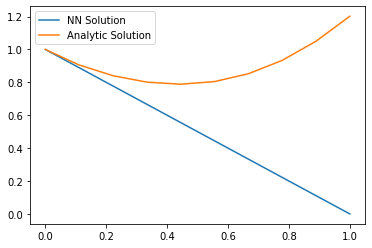

In [23]:
fvals = trial(x, wgts, params)
plt.plot(x, fvals, x, analytic_sol(x))
plt.legend(['NN Solution', 'Analytic Solution'])
plt.show()